<a href="https://colab.research.google.com/github/BStai/abm/blob/main/notebooks/abm_poc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%shell
pip install mesa StrEnum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 6.5 MB/s 
     |████████████████████████████████| 66 kB 5.5 MB/s 


In [354]:
import mesa
from typing import Tuple, List, Optional, Iterable
from dataclasses import dataclass
from enum import Enum
from strenum import StrEnum
import pandas as pd
from collections import Counter, defaultdict
from tqdm.notebook import tqdm, trange

In [273]:
# Utilities and global config
CARRIER_SPEED_PER_TICK = 3

def ceildiv(a, b):
  return -(a // -b)

def floordiv(a,b):
  return a // b

def chebychev_dist(start,end):
  return max(abs(a-b) for a, b in zip(start,end))

In [274]:
# Load class
class Load():
  """Class for simulated loads."""

  def __init__(self,  
               load_id: str,
               o: mesa.space.Position,
               d: mesa.space.Position,
               planned_tick: int, # scheduled "activity date"
               rate: Optional[int] = None
              ) -> None:
      self.load_id = load_id
      self.o = o
      self.d = d
      self.rate = rate
      self.planned_tick = planned_tick
      self.roll_count = 0
      self.is_booked = False
      self.is_picked = False
      self.is_dropped = False
  
  def __repr__(self):
    return f'''{self.load_id} OD[{self.o}{self.d}] @{self.planned_tick}-{self.get_drop_tick()}(+{self.roll_count}) ${self.rate} bpd[{int(self.is_booked)}{int(self.is_picked)}{int(self.is_dropped)}]'''

  def get_distance(self) -> int:
    """Get Chebyshev distance"""
    return chebychev_dist(self.o,self.d)

  def get_transit_time(self) -> int:
    """Get number of ticks expected to move"""
    dist = self.get_distance()
    required_ticks = ceildiv(dist, CARRIER_SPEED_PER_TICK)
    return required_ticks

  def get_drop_tick(self) -> int:
    """Get the tick the load will be dropped"""
    return self.planned_tick + self.get_transit_time()

  def get_rate_per(self) -> float:
    """get rate divided by distance"""
    return self.rate / self.get_distance()

  def book_load(self) -> None:
    """mark load as booked"""
    self.is_booked = True

  def update_load_state(self, current_tick: int) -> None:
    """auto update load, assuming no same-day booking"""
    if not self.is_booked and current_tick >= self.planned_tick:
      # need to roll forward another day
      self.planned_tick += 1
      self.roll_count += 1
      return
    
    if self.is_booked and current_tick < self.planned_tick:
      # state is waiting on pick, don't need to do anything
      return
    
    if self.is_booked and current_tick == self.planned_tick:
      # reached pick tick
      self.is_picked = True
      return
    
    if self.is_picked and current_tick >= self.get_drop_tick():
      # reached drop tick
      self.is_dropped = True
      return


In [344]:

class FreightMarketModel(mesa.Model):
    """Freight market model."""

    def __init__(self, n_shippers: int, n_carriers: int, width:int, height: int) -> None:
        self.n_shippers = n_shippers
        self.n_carriers = n_carriers
        self.carrier_grid = mesa.space.MultiGrid(width, height, torus=False)
        self.load_grid = mesa.space.MultiGrid(width, height, torus=False)
        self.schedule = mesa.time.RandomActivationByType(self)
        self.current_tick = 0

        # Create agents
        for i in range(self.n_shippers):
            a = ShipperAgent(i, self)
            self.schedule.add(a)
            #shippers don't have single location

        for i in range(self.n_shippers,self.n_shippers+self.n_carriers):
            a = CarrierAgent(unique_id= i, model= self, pos=None)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.carrier_grid.width)
            y = self.random.randrange(self.carrier_grid.height)
            self.carrier_grid.place_agent(a, (x, y))
        
        # set up datacollector
        self.datacollector = mesa.DataCollector(
            # model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
            model_reporters={"N_Loads": count_unbooked_loads, "N_Carriers": count_available_carriers,
                             "unbooked_roll_total": total_rolls_unbooked, "Carrier_States": count_carrier_states, }
        )

    def __repr__(self):
      return f"M@{self.current_tick}"

    def get_loads_available_to_book():
      """get full list of all avaliable loads"""
      pass


    def step(self):
      # don't shuffle types - shippers go first
      self.schedule.step(shuffle_types=False, shuffle_agents=True)
      self.datacollector.collect(self)
      self.current_tick += 1

def count_unbooked_loads(model: FreightMarketModel) -> int:
  return len([l for loads,_,_ in model.load_grid.coord_iter() for l in loads])

def count_available_carriers(model: FreightMarketModel) -> int:
  return len([c for carriers,_,_ in model.carrier_grid.coord_iter() for c in carriers])

def count_carrier_states(model: FreightMarketModel):
  return Counter((c.status.name for c in model.schedule.agents_by_type[CarrierAgent].values()))

def total_rolls_unbooked(model: FreightMarketModel):
  return sum((l.roll_count for loads,_,_ in model.load_grid.coord_iter() for l in loads))

#other metrics to track
# number of carriers in each state - deadheading, searching, in transit
# distribution of load states and rolls?


In [276]:
# Carrier Agent
class CarrierStatus(StrEnum):
  SEARCHING = "Searching for any load"
  DEADHEADING = "Traveling to next booked load"
  IN_TRANSIT = "Carrying load"

class CarrierAgent(mesa.Agent):
    """An agent simulating a carrier."""

    def __init__(self, unique_id: int, model: mesa.Model, pos: mesa.space.Position) -> None:
        super().__init__(unique_id, model)
        self.money = 0 #TODO make some kind of budgeting
        self.loads_moved: int = 0
        self.pos = pos
        self.load_queue: List[Load] = []
        self.current_load: Optional[Load] = None
        self.status = CarrierStatus.SEARCHING

    def __repr__(self):
      return f'C_{self.unique_id}'

    def can_pick_on_time(self, load: Load) -> bool:
      """ evaluate if agent is able to reach load by activity date"""
      if self.current_load:
        t = self.current_load.get_drop_tick()
        pos = self.current_load.d
      else:
        t = self.model.current_tick
        pos = self.pos

      n_ticks_to_pick = load.planned_tick - t
      return CARRIER_SPEED_PER_TICK * n_ticks_to_pick >= chebychev_dist(pos, load.o)

    def does_not_conflict_with_current(self, load: Load) -> bool:
      """check that a load does not conflict with current """
      # this isn't gonna apply when booking more than one out
      if self.current_load is None:
        return True
      return load.planned_tick > self.current_load.get_drop_tick()

    def search_pos_for_load(self, pos: mesa.space.Position):
       search_neighborhood = self.model.load_grid.get_neighborhood(
              pos=pos, moore=True, include_center=True, radius=1)
       load_list = self.model.load_grid.get_cell_list_contents(search_neighborhood) 
       return load_list

    def add_to_load_queue(self) -> None:
      """search for available loads and book"""
    
      if len(self.load_queue) == 0: # start with only searching for the next load when none booked
        # if no current load - search by current position
        if self.current_load is None:
          load_list = self.search_pos_for_load(self.pos)
        else:
          load_list = self.search_pos_for_load(self.current_load.d)
        # if current load - search from drop position
        if len(load_list) == 0:
          return
        # filter to ones that can handle 
        load_list = [l for l in load_list if 
                     l is not None and
                     self.can_pick_on_time(l) and
                     self.does_not_conflict_with_current(l)
                     ]
        if len(load_list) > 0 :
          selected_load = self.random.choice(load_list)
        else:
          return
      
        # book load and add to queue
        selected_load.book_load()
        self.model.load_grid.remove_agent(selected_load) # shippers put loads on load grid, carriers remove on booking
        self.load_queue.append(selected_load)


    def handle_current_load(self):
      # take one off the load queue if not currently processing
      if not self.current_load:
        if len(self.load_queue) > 0:
          self.current_load = self.load_queue.pop(0)
          self.model.carrier_grid.remove_agent(self)
        else:
          self.status = CarrierStatus.SEARCHING # should already be set anyways
          return # no load to handle
      
      # if have a current load
      if self.current_load.planned_tick > self.model.current_tick:
        self.status = CarrierStatus.DEADHEADING
      elif ((self.current_load.planned_tick <= self.model.current_tick) and
            (self.current_load.get_drop_tick() > self.model.current_tick)
        ):
        self.status = CarrierStatus.IN_TRANSIT
      else:
        # current load has been delivered
        self.loads_moved += 1
        self.money += self.current_load.rate

        if len(self.load_queue) == 0:
          self.model.carrier_grid.place_agent(self, self.current_load.d)
          self.current_load = None
          self.status = CarrierStatus.SEARCHING
        else:
          # set next up in load queue as current load
          self.current_load = self.load_queue.pop(0)
          self.status = CarrierStatus.DEADHEADING



    def move_while_searching(self):
      # should berandom walk
      # for now just stay put. Very boring carrier
      pass


    def step(self):
      self.add_to_load_queue()
      self.handle_current_load()
      if self.status == CarrierStatus.SEARCHING:
        self.move_while_searching()

In [291]:
# Shipper Agent 

class ShipperAgent(mesa.Agent):
  """An agent simulating a shipper."""

  def __init__(self, unique_id: int, model: FreightMarketModel) -> None:
      super().__init__(unique_id, model)
      self.loads: List[Load] = []
  
  def get_rate(self, load: Load):
    """pick a rate to put on a load"""
    dist = load.get_distance()
    rate = 3 * dist #fixed rate per distance to start
    return rate

  def spawn_loads(self, current_tick: int) -> None:
    """Spawn new loads."""
    #spawn on load to start 
    #cap number of unbooked loads 
    if len(self.get_unbooked_loads()) >= 50:
      return 

    #id is "shipper id_tick spawned_n"
    load_id = str(self.unique_id) + "_" +  str(self.model.current_tick) + "_0"
    w = self.model.load_grid.width
    h = self.model.load_grid.height
    o = self.random.randrange(w), self.random.randrange(h)
    d = self.random.randrange(w), self.random.randrange(h)
    planned_tick = current_tick + 3 # start with making all new loads 3 ticks out
    load = Load(load_id=load_id, o = o, d = d, planned_tick=planned_tick)
    load.rate = self.get_rate(load)

    self.loads.append(load)
    self.model.load_grid.place_agent(load, load.o) # shippers put loads on load grid, carriers remove on booking

  def manage_loads(self, current_tick: int) -> None:
    """Update loads"""
    for load in self.loads:
      load.update_load_state(current_tick)
    # eventually do some sort of rate adjustments here

  def step(self):
    self.spawn_loads(self.model.current_tick)
    self.manage_loads(self.model.current_tick)

  def get_unbooked_loads(self) -> List[Load]:
    return [x for x in self.loads if not x.is_booked]


In [409]:
model = FreightMarketModel(n_shippers=50,n_carriers=400, width=40, height=10)
for i in trange(500):
    model.step()

  0%|          | 0/500 [00:00<?, ?it/s]

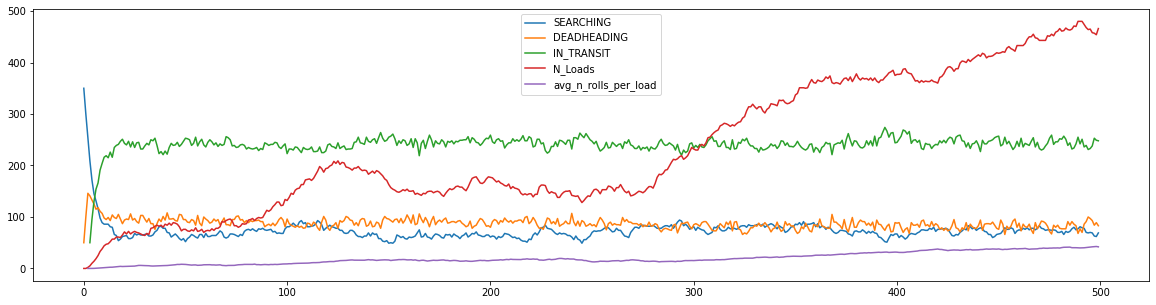

In [410]:
tmp = model.datacollector.get_model_vars_dataframe()
tmp = pd.concat([ tmp['Carrier_States'].apply(pd.Series),tmp.drop(['Carrier_States'], axis=1)], axis=1)
tmp['avg_n_rolls_per_load'] = tmp['unbooked_roll_total'] / tmp['N_Loads']
tmp = tmp.drop(['unbooked_roll_total','N_Carriers'], axis=1)
tmp.plot(figsize=(20,5))

Questions
- What ratio of cells, n_shippers, n_carriers, load spawn rate, carrier search radius etc corresponds to different ratios of carrier state, and unbooked load counts?
- 

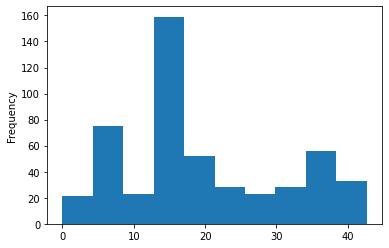

In [411]:
tmp['avg_n_rolls_per_load'].plot.hist()
# Interesting. Exponential distribution of avg roll count by tick. - when loads don't accumulate to max
# no distinguishing features of loads that would make one "hard to ship"
# no geographic preference for loads occuring in any one place

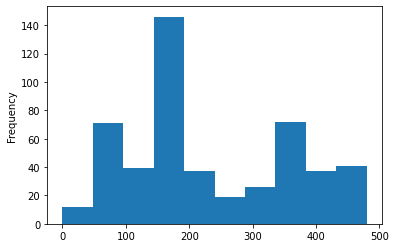

In [412]:
tmp['N_Loads'].plot.hist()
# generally the same

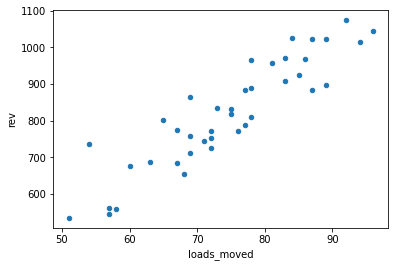

In [413]:
gdf = pd.DataFrame([(c.loads_moved, c.money) for c in model.schedule.agents_by_type[CarrierAgent].values()],
                   columns=['loads_moved','rev'])
df.plot.scatter(x="loads_moved",y="rev")

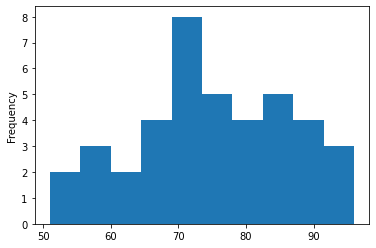

In [414]:
df.loads_moved.plot.hist()
# ok so the loads moved looks pretty normally distributed
# maaaybe a little skewed on the right tail?